In [1]:
"""
Mem3dg implementations of `process_bigraph.Process()` interface
"""

'\nMem3dg implementations of `process_bigraph.Process()` interface\n'

In [9]:
from bsp import app_registrar

app_registrar.registered_addresses

['console-emitter',
 'ram-emitter',
 'composite',
 'cobra-process',
 'sed-cobra-process',
 'dynamic-fba',
 'copasi-process',
 'sed-copasi-process',
 'membrane-process',
 'simple-membrane-process',
 'smoldyn-process']

In [12]:
import numpy as np

# Osmotic parameters for the kth instance
osmotic_params_k = {
    "preferred_volume": 1e-12,  # Preferred volume in liters
    "reservoir_volume": 0,      # Reservoir volume (not used here)
    "strength": 0.1,            # Osmotic strength
    "current_volume": 9e-13,    # Current volume in liters
}

# Calculate preferred area
V_preferred = osmotic_params_k["preferred_volume"]  # Preferred volume in liters




preferred_area_k = calculate_preferred_area(V_preferred)
print(f"Preferred Area (k): {preferred_area_k:.2f} μm²")


Preferred Area (k): 483.60 μm²


In [11]:
from process_bigraph import Composite, pp
from bsp.utils.base_utils import new_document
import numpy as np


test_state_init_fp = '../test-membrane-initial.json'
oblate = "../fixtures/sample_meshes/oblate.ply"
prolate = "../fixtures/sample_meshes/prolate.ply"

membrane_config = {
    # 'mesh_file': oblate,
    'geometry': {
        'type': 'icosphere',
        'params': {
            'radius': 1.0,
            'subdivision': 2
        }
    },
    'tension_model': {
        'modulus': 0.1, 
        'preferredArea': 12.4866
    },
    'osmotic_model': {
        'preferredVolume': 0.7 * np.pi * 4 / 3,
        'reservoirVolume': 0,
        'strength': 0.02
    },
    'parameters': {
        'bending': {
            'Kbc': 8.22e-5
        }
    },
    'save_period': 100,
    'tolerance': 1e-11,
    'characteristic_time_step': 2
}

membrane_port_stores = {
    'geometry': ['geometry_store'],
    "velocities": ["velocities_store"]
    # "parameters": ["parameters_store"],
}

state = new_document(
    name='membrane', 
    address='simple-membrane-process',
    _type='process', 
    config=membrane_config, 
    inputs=membrane_port_stores,
    outputs=membrane_port_stores,
    add_emitter=False
)

state['emitter'] = {
    'address': 'local:ram-emitter',
    '_type': 'step',
    'config': {
        'emit': {
            # "geometry": {
            #     "faces": "list[list[integer]]",
            #     "vertices": "list[list[float]]",
            # },
            'velocities': 'list',
            "geometry": 'tree'
            # "parameters": "tree[float]",
            # "velocities": "list[list[float]]"
        }
    },
    'inputs': { 
        'geometry': ['geometry_store'],
        'velocities': ['velocities_store']
    }
}
        
simulation = Composite(
    config={'state': state},
    core=app_registrar.core
)

pp(simulation.state.keys())

dict_keys(['global_time', 'membrane', 'emitter', 'geometry_store', 'velocities_store'])


In [4]:
# define simulation.run param, aka: total_time in mem3dg?

simulation.run(10)

Initialized NetCDF file at /var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/tmpe6e2z0m5/traj.nc

t: 0, n: 0, isSmooth: 1
A, tension: 12.3298, -0.00125536, V, pressure: 4.04704, -0.00259352, h: 1
nFaces: 320
minE: 0.275904; maxE: 0.32492
minA: 0.0360323; maxA: 0.0457144
E_total: 0.00362552
E_kin: 0
E_pot: 0.00362552
W_ext: 0
|e|Mech: 0.00025738
|e|Chem: 0
H: [1.00215,1.14736]
K: [1.00821,1.15383]
phi: [1,1]
sum_phi: 12.3298
H0: [0,0]

Reached time.

t: 2, n: 1, isSmooth: 1
A, tension: 12.3297, -0.00125659, V, pressure: 4.04698, -0.00259337, h: 0.999992
nFaces: 320
minE: 0.275892; maxE: 0.32492
minA: 0.0360305; maxA: 0.0457145
E_total: 0.00362542
E_kin: 3.31224e-08
E_pot: 0.00362539
W_ext: 0
|e|Mech: 6.62447e-08
|e|Chem: 0
H: [1.00229,1.14272]
K: [1.00845,1.14447]
phi: [1,1]
sum_phi: 12.3297
H0: [0,0]
Simulation finished, and data saved to /var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/tmpe6e2z0m5
Closed NetCDF file
Initialized NetCDF file at /var/folders/yy/8crj8x7x5_3b86f0js6_0bn0000

In [5]:
results = simulation.gather_results()

In [8]:
results[('emitter',)][-1]['geometry']['vertices'][0], results[('emitter',)][-1]['geometry']['vertices'][-1]

([-0.5251591334117481, 0.8497253273626487, 1.8634724839594607e-19],
 [0.8505559144342514, 0.5257050078941109, -2.1006417091906648e-19])

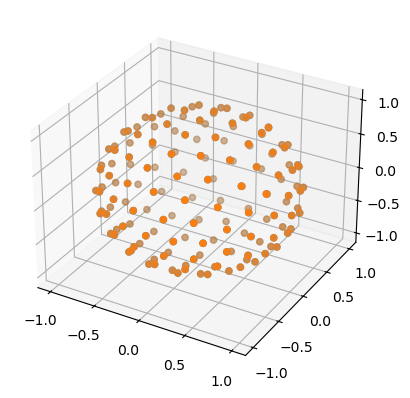

In [7]:
import os
from pathlib import Path
p = Path('/var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/tmpf9dvc1on')

def plot_trajectory_change(outputDir):
    import pymem3dg.visual as dg_vis
    import matplotlib.pyplot as plt

    from netCDF4 import Dataset

    data = Dataset(str(outputDir / "traj.nc"),'r')
    # get data parameters
    data.groups['Trajectory'].variables

    # get the coordinates from groups/trajectory.variables
    x = data.groups['Trajectory'].variables['coordinates'][:]

    # plot x[] in 3d spaces
    # where the array is xyz, xyz, xyz

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x[0][::3], x[0][1::3], x[0][2::3])
    ax.scatter(x[-1][::3], x[-1][1::3], x[-1][2::3])

    plt.show()



plot_trajectory_change(p)

In [6]:
results[('emitter',)][-1]['geometry']['vertices']

[[-0.5256615261866213, 0.8505382159480962, 6.522153693858113e-20],
 [0.5256615261866213, 0.8505382159480962, -3.134021904840911e-20],
 [-0.5256615261866213, -0.8505382159480962, -4.319868030996932e-20],
 [0.5256615261866213, -0.8505382159480962, 6.522153693858113e-20],
 [1.3929252659348113e-19, -0.5256615261866213, 0.8505382159480962],
 [-1.3552527156068805e-19, 0.5256615261866213, 0.8505382159480962],
 [-1.2874900798265365e-19, -0.5256615261866213, -0.8505382159480962],
 [1.2874900798265365e-19, 0.5256615261866213, -0.8505382159480962],
 [0.8505382159480962, 1.2374342349295e-19, -0.5256615261866213],
 [0.8505382159480962, -1.2790197503539935e-19, 0.5256615261866213],
 [-0.8505382159480962, -3.3034284942917713e-20, -0.5256615261866213],
 [-0.8505382159480962, 7.74591214439172e-20, 0.5256615261866213],
 [-0.8090105015334922, 0.4999959872032971, 0.30901451433019506],
 [-0.4999959872032971, 0.30901451433019506, 0.8090105015334922],
 [-0.30901451433019506, 0.8090105015334922, 0.49999598720

In [1]:
test_state_init_fp = '../test-membrane-initial.json'
oblate = "../fixtures/sample_meshes/oblate.ply"
prolate = "../fixtures/sample_meshes/prolate.ply"

membrane_config = {
    'mesh_file': oblate,
    'tension_model': {
        'modulus': 0.1, 
        'preferredArea': 12.4866
    },
    'osmotic_model': {
        'preferredVolume': 0.7 * 3.14 * 4 / 3,
        'reservoirVolume': 0,
        'strength': 0.02
    },
    'parameters': {
        'bending': {
            'Kbc': 8.22e-5
        }
    },
    'save_period': 100,
    'tolerance': 1e-11,
    'characteristic_time_step': 2
}

In [2]:
import pymem3dg as dg
from functools import partial
import pymem3dg.boilerplate as dgb
from pathlib import Path


p = dg.Parameters()

p.bending.Kbc = 8.22e-5

p.tension.form = partial(
    dgb.preferredAreaSurfaceTensionModel, modulus=0.1, preferredArea=12.4866
)
p.osmotic.form = partial(
    dgb.preferredVolumeOsmoticPressureModel,
    preferredVolume=0.7 * 3.14 * 4 / 3,
    reservoirVolume=0,
    strength=0.02,
)

In [3]:
# geo = dg.Geometry(oblate)
#
# outputDir = Path("output/tutorial1/biconcave")
# outputDir.mkdir(parents=True, exist_ok=True)
#
# g = dg.System(geometry=geo, parameters = p)
# g.initialize()
#
# fe = dg.Euler(system = g, characteristicTimeStep = 2,
#               totalTime = 10000, savePeriod = 100,
#               tolerance = 1e-11, outputDirectory = str(outputDir))
# # Uncomment to print intermediate statistics
# fe.ifPrintToConsole = True
# fe.ifOutputTrajFile = True
# success = fe.integrate()


In [4]:
geo = dg.Geometry(oblate)

outputDir = Path("output/tutorial1/biconcave")
outputDir.mkdir(parents=True, exist_ok=True)

g = dg.System(geometry=geo, parameters = p)
g.initialize()

for interval in range(10):
    fe = dg.Euler(system = g, characteristicTimeStep = 1,
                  totalTime = interval, savePeriod = interval,
                  tolerance = 1e-11, outputDirectory = str(outputDir))
    # Uncomment to print intermediate statistics
    fe.ifPrintToConsole = True
    fe.ifOutputTrajFile = True
    # fe.step(1)
    # fe.saveData(True, True, True)
    fe.integrate()

Initialized NetCDF file at output/tutorial1/biconcave/traj.nc

t: 0, n: 0, isSmooth: 1
A, tension: 12.4783, -6.6788e-05, V, pressure: 4.02477, -0.00254775, h: 0.80235
nFaces: 892
minE: 0.14732; maxE: 0.217463
minA: 0.0124267; maxA: 0.0156246
E_total: 0.00358869
E_kin: 0
E_pot: 0.00358869
W_ext: 0
|e|Mech: 0.00158791
|e|Chem: 0
H: [0.61458,1.48814]
K: [0.411476,1.78376]
phi: [1,1]
sum_phi: 12.4783
H0: [0,0]

Reached time.

t: 1, n: 1, isSmooth: 1
A, tension: 12.4766, -8.01784e-05, V, pressure: 4.02398, -0.00254591, h: 0.8023
nFaces: 892
minE: 0.147312; maxE: 0.217459
minA: 0.0124254; maxA: 0.0156234
E_total: 0.00358747
E_kin: 1.26072e-06
E_pot: 0.0035862
W_ext: 0
|e|Mech: 2.52145e-06
|e|Chem: 0
H: [0.616192,1.47833]
K: [0.413632,1.75882]
phi: [1,1]
sum_phi: 12.4766
H0: [0,0]
Simulation finished, and data saved to output/tutorial1/biconcave
Closed NetCDF file
Initialized NetCDF file at output/tutorial1/biconcave/traj.nc

t: 1, n: 0, isSmooth: 1
A, tension: 12.4766, -8.01784e-05, V, press

In [7]:
# plot the netcdf data in outputDir/"traj.nc" in matplotlib

def plot_trajectory_change(outputDir):
    import pymem3dg.visual as dg_vis
    import matplotlib.pyplot as plt

    from netCDF4 import Dataset

    data = Dataset(str(outputDir / "traj.nc"),'r')
    # get data parameters
    data.groups['Trajectory'].variables

    # get the coordinates from groups/trajectory.variables
    x = data.groups['Trajectory'].variables['coordinates'][:]

    # plot x[] in 3d spaces
    # where the array is xyz, xyz, xyz

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x[0][::3], x[0][1::3], x[0][2::3])
    ax.scatter(x[-1][::3], x[-1][1::3], x[-1][2::3])

    plt.show()

NameError: name 'Path' is not defined

In [17]:
import shutil

shutil.rmtree(str(outputDir))